In [1]:
import pandas as pd
import numpy as np
import branched_resnet_v2 as br
from torchvision import transforms

# Load saved dataset artifact (.npz) and configure for training
npz_path = 'data/multi_cancer/adenocarcinoma_dataset.npz'
data = np.load(npz_path)

# Extract arrays
images = data['images']                 # (N, H, W, 3) or (N, H, W)
labels1 = data['labels1'].astype(np.int64)  # primary labels (e.g., class ids)
labels2 = data['labels2'].astype(np.int64)  # secondary labels (e.g., domain/binary)

# Text metadata aligned 1:1 with dataset
domain_text_list = data['domain_text'].astype(str).tolist()
sub_domain_text_list = data['sub_domain_text'].astype(str).tolist()

# Define transform appropriate for RGB arrays (no grayscale channel repeat)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Build dataset compatible with the training pipeline
dataset = br.CustomImageDataset(images=images, labels1=labels1, labels2=labels2, transform=transform)

# Quick sanity check
print('Loaded shapes:', images.shape, labels1.shape, labels2.shape)
sample = dataset[0]
print({k: (v.shape if hasattr(v, 'shape') else v) for k, v in sample.items()})
print('domain_text[0]:', domain_text_list[0])
print('sub_domain_text[0]:', sub_domain_text_list[0])


Loaded shapes: (45000, 224, 224, 3) (45000,) (45000,)
{'pixel_values': torch.Size([3, 224, 224]), 'labels1': 15, 'labels2': 0}
domain_text[0]: Lung and Colon Cancer
sub_domain_text[0]: colon_bnt
Loaded shapes: (45000, 224, 224, 3) (45000,) (45000,)
{'pixel_values': torch.Size([3, 224, 224]), 'labels1': 15, 'labels2': 0}
domain_text[0]: Lung and Colon Cancer
sub_domain_text[0]: colon_bnt


In [2]:
import torch

print(torch.__version__)

# Set device and verify CUDA availability
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f'Using device: {device}')

2.6.0+cu118
CUDA available: True
CUDA version: 11.8
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070
Using device: cuda


In [3]:
# Split dataset into train/val/test while keeping domain and subdomain text aligned
from typing import List, Optional, Tuple
import numpy as np

try:
    # Prefer v2 dataset class if available
    from branched_resnet_v2 import CustomImageDataset
except Exception:
    from branched_resnet import CustomImageDataset


def _per_class_split(idxs: List[int], ratios: Tuple[float, float, float], rng: np.random.Generator):
    idxs = list(idxs)
    rng.shuffle(idxs)
    n = len(idxs)
    t_ratio, v_ratio, s_ratio = ratios
    # initial floors
    n_train = int(np.floor(t_ratio * n))
    n_val = int(np.floor(v_ratio * n))
    n_test = n - n_train - n_val
    # guard against negatives due to rounding
    if n_test < 0:
        n_test = 0
        n_val = min(n_val, n - n_train)
    train = idxs[:n_train]
    val = idxs[n_train:n_train + n_val]
    test = idxs[n_train + n_val:]
    return train, val, test


def _per_class_split_two(idxs: List[int], ratios: Tuple[float, float], rng: np.random.Generator):
    """
    Split indices into two buckets (train, val) according to ratios that sum to 1.
    """
    idxs = list(idxs)
    rng.shuffle(idxs)
    n = len(idxs)
    t_ratio, v_ratio = ratios
    s = t_ratio + v_ratio
    if s <= 0:
        raise ValueError("Train+Val ratios must be > 0")
    # Normalize in case of tiny float drift
    t_ratio = t_ratio / s
    v_ratio = v_ratio / s
    n_train = int(np.floor(t_ratio * n))
    train = idxs[:n_train]
    val = idxs[n_train:]
    return train, val


def split_dataset_with_text(
    dataset: CustomImageDataset,
    domain_text_list: List[str],
    sub_domain_text_list: List[str],
    target_domain: str,  # Branch2 will be 1 if domain==target_domain else 0
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    stratify_on: Optional[str] = "labels1",  # 'labels1', 'labels2', or None (labels2 refers to original labels; stratification is applied before relabeling)
    shuffle: bool = True,
    seed: int = 42,
    excluded_domain: Optional[str] = None,  # When set, test split contains ONLY this domain
):
    """
    Split a CustomImageDataset into train/val/test while preserving alignment with
    domain_text_list and sub_domain_text_list.

    Branch2 labeling:
      - For all returned datasets, labels2 will be a binary vector: 1 if sample's domain_text == target_domain, else 0.

    Modes:
      - Default: random/stratified 3-way split by ratios (train/val/test sum to 1.0).
      - Exclude-domain: if excluded_domain is provided, test set is ALL samples whose
        domain_text equals excluded_domain. Train/val are drawn from the remaining
        samples using renormalized ratios train_size : val_size (test_size ignored).

    Returns:
      (train_ds, val_ds, test_ds, train_domain, val_domain, test_domain, train_sub, val_sub, test_sub)
    """
    N = len(dataset)
    if len(domain_text_list) != N or len(sub_domain_text_list) != N:
        raise ValueError("domain_text_list and sub_domain_text_list must match dataset length")

    # Coerce to arrays for indexing
    domain_text_arr = np.asarray(domain_text_list)
    sub_text_arr = np.asarray(sub_domain_text_list)
    # Prepare binary labels2 based on target_domain (1 for target, 0 otherwise)
    binary_labels2_full = (domain_text_arr == target_domain).astype(np.int64)

    rng = np.random.default_rng(seed)

    # Helper to build subset dataset preserving the original transform AND applied binary labels2
    def build_subset(indices):
        images = dataset.images[indices]
        labels1 = dataset.labels1[indices]
        labels2 = binary_labels2_full[indices]  # apply binary relabeling here
        return CustomImageDataset(images=images, labels1=labels1, labels2=labels2, transform=getattr(dataset, 'transform', None))

    if excluded_domain is not None:
        # Test set is the excluded domain
        test_idx = np.where(domain_text_arr == excluded_domain)[0]
        if test_idx.size == 0:
            raise ValueError(f"excluded_domain '{excluded_domain}' not found in domain_text_list")
        remain_idx = np.setdiff1d(np.arange(N), test_idx)
        if remain_idx.size == 0:
            raise ValueError("No samples remain for train/val after excluding the domain.")

        # Renormalize train/val
        if train_size <= 0 and val_size <= 0:
            raise ValueError("At least one of train_size or val_size must be > 0 when excluding a domain.")
        t_ratio = float(train_size)
        v_ratio = float(val_size)
        s = t_ratio + v_ratio
        if s <= 0:
            s = 1.0
            t_ratio, v_ratio = 1.0, 0.0
        t_ratio /= s
        v_ratio /= s

        if stratify_on in ("labels1", "labels2"):
            labels = np.asarray(getattr(dataset, stratify_on)).reshape(-1)
            buckets = {}
            for i in remain_idx:
                buckets.setdefault(int(labels[i]), []).append(i)
            train_idx, val_idx = [], []
            for _, idxs in buckets.items():
                t, v = _per_class_split_two(idxs, (t_ratio, v_ratio), rng)
                train_idx.extend(t)
                val_idx.extend(v)
            if shuffle:
                rng.shuffle(train_idx)
                rng.shuffle(val_idx)
        else:
            idxs = remain_idx.copy()
            if shuffle:
                rng.shuffle(idxs)
            n = idxs.size
            n_train = int(np.floor(t_ratio * n))
            train_idx = idxs[:n_train]
            val_idx = idxs[n_train:]

        # Build datasets and aligned texts
        train_ds = build_subset(train_idx)
        val_ds = build_subset(val_idx)
        test_ds = build_subset(test_idx)

        train_domain = domain_text_arr[train_idx].tolist()
        val_domain = domain_text_arr[val_idx].tolist()
        test_domain = domain_text_arr[test_idx].tolist()

        train_sub = sub_text_arr[train_idx].tolist()
        val_sub = sub_text_arr[val_idx].tolist()
        test_sub = sub_text_arr[test_idx].tolist()

        return (
            train_ds, val_ds, test_ds,
            train_domain, val_domain, test_domain,
            train_sub, val_sub, test_sub,
        )

    # Default behavior: 3-way split over all samples
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size + val_size + test_size must sum to 1.0")

    # Choose indices by stratification or random
    if stratify_on in ("labels1", "labels2"):
        labels = np.asarray(getattr(dataset, stratify_on)).reshape(-1)
        buckets = {}
        for i, lab in enumerate(labels):
            buckets.setdefault(int(lab), []).append(i)
        train_idx, val_idx, test_idx = [], [], []
        ratios = (train_size, val_size, test_size)
        for _, idxs in buckets.items():
            t, v, s = _per_class_split(idxs, ratios, rng)
            train_idx.extend(t)
            val_idx.extend(v)
            test_idx.extend(s)
        if shuffle:
            rng.shuffle(train_idx)
        
            rng.shuffle(val_idx)
            rng.shuffle(test_idx)
    else:
        all_idx = np.arange(N)
        if shuffle:
            rng.shuffle(all_idx)
        n_train = int(np.floor(train_size * N))
        n_val = int(np.floor(val_size * N))
        train_idx = all_idx[:n_train]
        val_idx = all_idx[n_train:n_train + n_val]
        test_idx = all_idx[n_train + n_val:]

    # Build datasets
    train_ds = build_subset(train_idx)
    val_ds = build_subset(val_idx)
    test_ds = build_subset(test_idx)

    # Build aligned text lists
    train_domain = domain_text_arr[train_idx].tolist()
    val_domain = domain_text_arr[val_idx].tolist()
    test_domain = domain_text_arr[test_idx].tolist()

    train_sub = sub_text_arr[train_idx].tolist()
    val_sub = sub_text_arr[val_idx].tolist()
    test_sub = sub_text_arr[test_idx].tolist()

    return (
        train_ds, val_ds, test_ds,
        train_domain, val_domain, test_domain,
        train_sub, val_sub, test_sub,
    )

In [ ]:
# Example usage (adjust variable names to your notebook context)
# Assumes you have variables: dataset (CustomImageDataset), domain_text_list, sub_domain_text_list
# If your variables are different, replace them accordingly.
try:
    dataset
    domain_text_list
    sub_domain_text_list
except NameError:
    print("Define 'dataset', 'domain_text_list', and 'sub_domain_text_list' before running this cell.")
else:
    # Choose your TARGET DOMAIN (used to build binary labels2: 1 if domain==target_domain else 0)
    target_domain = 'Breast Cancer'  # <-- change to your target organ/domain text
    
    # Optionally, also choose an EXCLUDED DOMAIN for a leave-one-domain-out test split.
    # If you want the test set to be ONLY the target domain, set excluded_domain = target_domain.
    excluded_domain = None  # or set to None to use a normal 3-way split
    
    (
        train_ds, val_ds, test_ds,
        train_domain, val_domain, test_domain,
        train_sub, val_sub, test_sub,
    ) = split_dataset_with_text(
        dataset=dataset,
        domain_text_list=domain_text_list,
        sub_domain_text_list=sub_domain_text_list,
        target_domain=target_domain,
        train_size=0.7,
        val_size=0.15,   # Renormalized with train_size when excluded_domain is set
        test_size=0.15,  # Ignored when excluded_domain is set
        stratify_on="labels1",  # or 'labels2' or None
        shuffle=True,
        seed=42,
        excluded_domain=excluded_domain
)
    
    print(
        "train/val/test sizes:", len(train_ds), len(val_ds), len(test_ds),
        "\ntrain sample domain/sub:", train_domain[0] if len(train_domain) else None, 
        "\ntrain sample sub_domain:", train_sub[0] if len(train_sub) else None,
)
    
    # Sanity checks
    from collections import Counter
    import numpy as np
    
    N0 = len(dataset)
    assert (len(train_ds) + len(val_ds) + len(test_ds)) == N0, "Split sizes do not sum to the original dataset size"
    
    # Domain text distribution should match original counts (multiset equality)
    counts_orig_domain = Counter(domain_text_list)
    counts_split_domain = Counter(train_domain) + Counter(val_domain) + Counter(test_domain)
    assert counts_split_domain == counts_orig_domain, "Domain distribution across splits does not match original data"
    
    # Subdomain text distribution should also match original counts
    counts_orig_sub = Counter(sub_domain_text_list)
    counts_split_sub = Counter(train_sub) + Counter(val_sub) + Counter(test_sub)
    assert counts_split_sub == counts_orig_sub, "Sub-domain distribution across splits does not match original data"
    
    # Alignment checks: lengths of datasets and their text lists must match
    assert len(train_domain) == len(train_ds) == len(train_sub), "Train text lists not aligned with dataset"
    assert len(val_domain) == len(val_ds) == len(val_sub), "Val text lists not aligned with dataset"
    assert len(test_domain) == len(test_ds) == len(test_sub), "Test text lists not aligned with dataset"
    
    # Binary label checks for branch2 mapping (labels2 == 1 if domain==target_domain else 0)
    def check_binary_mapping(ds, dom_list, split_name):
        arr = np.asarray(ds.labels2).reshape(-1)
        uniq = set(np.unique(arr).tolist())
        assert uniq.issubset({0,1}), f"{split_name}: labels2 not binary: {uniq}"
        expected = np.array([1 if d == target_domain else 0 for d in dom_list], dtype=np.int64)
        assert arr.shape == expected.shape, f"{split_name}: labels2 shape mismatch vs domain_text list"
        mismatches = int(np.sum(arr != expected))
        assert mismatches == 0, f"{split_name}: {mismatches} samples have incorrect labels2 mapping to target_domain"
        print(f"{split_name}: labels2 binary and correctly mapped to target_domain '{target_domain}'.")
    
    check_binary_mapping(train_ds, train_domain, "Train")
    check_binary_mapping(val_ds, val_domain, "Val")
    check_binary_mapping(test_ds, test_domain, "Test")
    
    # Exclusion checks (if applicable): test contains only the excluded domain and others contain none of it
    if excluded_domain is not None:
        assert set(test_domain) == {excluded_domain}, f"Test set contains domains other than '{excluded_domain}'"
        assert excluded_domain not in set(train_domain), f"Train set contains excluded domain '{excluded_domain}'"
        assert excluded_domain not in set(val_domain), f"Val set contains excluded domain '{excluded_domain}'"
        print(f"Exclusion check passed: test only contains '{excluded_domain}'.")
    
    print("Sanity checks passed: splits and binary labels2 are correctly formed and aligned.")

train/val/test sizes: 31500 13500 0 
train sample domain/sub: Lung and Colon Cancer 
train sample sub_domain: lung_scc
Train: labels2 binary and correctly mapped to target_domain 'Breast Cancer'.
Val: labels2 binary and correctly mapped to target_domain 'Breast Cancer'.
Test: labels2 binary and correctly mapped to target_domain 'Breast Cancer'.
Sanity checks passed: splits and binary labels2 are correctly formed and aligned.


In [5]:
print(train_ds[0]['labels2'])

for sample in train_ds:
    assert sample['labels2'] in (0, 1)


0


In [6]:
# print the unique values in train_domain
print(set(train_domain))

{'Lung and Colon Cancer', 'Breast Cancer', 'Kidney Cancer'}


In [7]:
from transformers import Trainer, TrainingArguments, set_seed
import datetime

DATE = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Set output directory
output_dir = f'./data/AC_results/Breast/'

# Set Hyperparameters
NUM_EPOCHS = 50
lr = 0.1
OPTIM = 'sgd'
WEIGHT_DECAY = 1e-4
SEED = 42

# Set seed
torch.manual_seed(SEED)
set_seed(SEED)

def run_experiment(lambda_scheduler, from_checkpoint=None):
    # Derive class counts from loaded data to avoid label-out-of-range CUDA errors
    num_d1_classes = int(np.max(dataset.labels1)) + 1
    num_d2_classes = int(np.max(dataset.labels2)) + 1
    print(f"Using num_d1_classes={num_d1_classes}, num_d2_classes={num_d2_classes}")

    # Initialize model
    config = br.ResNetConfig()
    model = br.ResNetForMultiLabel(
        config=config,
        num_d1_classes=num_d1_classes,
        num_d2_classes=num_d2_classes,
        lamb=0,
    )

    scheduler_name = lambda_scheduler.__name__

    # Set training arguments
    training_args = TrainingArguments(
            output_dir=f"{output_dir}/{scheduler_name}_results_{DATE}",
            num_train_epochs=NUM_EPOCHS,
            per_device_train_batch_size=32,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_dir='./logs',
            logging_steps=10,
            load_best_model_at_end=True,
            learning_rate=lr,
            weight_decay=WEIGHT_DECAY,
            seed=SEED,
            optim=OPTIM
        )

    trainer = Trainer(
        model = model,
        args = training_args,
        train_dataset= train_ds,
        eval_dataset= val_ds,
        compute_metrics=br.make_metrics_fn(model),
        callbacks=[br.LambdaUpdateCallback(model, lambda_scheduler, NUM_EPOCHS)]
    )
    if from_checkpoint != None:
        trainer.train(resume_from_checkpoint=from_checkpoint)
    else:
        trainer.train()
        
    trainer.save_model(f"{output_dir}/{scheduler_name}_final_model_{DATE}")

    metrics = trainer.evaluate()

    return metrics



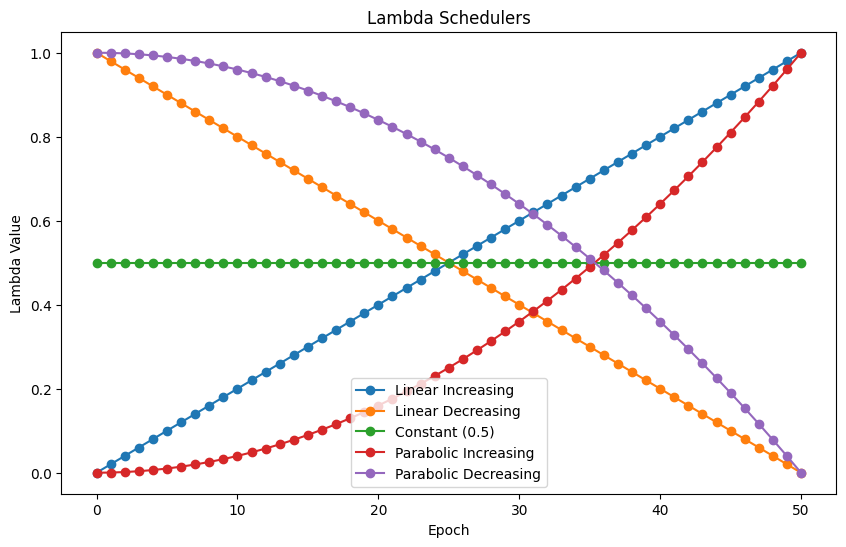

In [8]:
NUM_EPOCHS = 50

def linear_increasing_lambda_scheduler(epoch, total_epochs):
    return epoch / total_epochs

def linear_decreasing_lambda_scheduler(epoch, total_epochs):
    return 1 - (epoch / total_epochs)

def constant_lambda_scheduler(epoch=None, total_epochs=None, lambda_value=0.5):
    return lambda_value

def parabolic_increasing_lambda_scheduler(epoch, total_epochs, start_value=0.0, end_value=1.0):
    progress = epoch / total_epochs
    return start_value + (end_value - start_value) * (progress ** 2)

def parabolic_decreasing_lambda_scheduler(epoch, total_epochs, start_value=0.0, end_value=1.0):
    progress = epoch / total_epochs
    return end_value - (end_value - start_value) * (progress ** 2)

# Plot lambda schedulers
import matplotlib.pyplot as plt

epochs = np.arange(0, NUM_EPOCHS + 1)
linear_increasing = [linear_increasing_lambda_scheduler(e, NUM_EPOCHS) for e in epochs]
linear_decreasing = [linear_decreasing_lambda_scheduler(e, NUM_EPOCHS) for e in epochs]
constant = [constant_lambda_scheduler() for e in epochs]
parabolic_increasing = [parabolic_increasing_lambda_scheduler(e, NUM_EPOCHS) for e in epochs]
parabolic_decreasing = [parabolic_decreasing_lambda_scheduler(e, NUM_EPOCHS) for e in epochs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, linear_increasing, label='Linear Increasing', marker='o')
plt.plot(epochs, linear_decreasing, label='Linear Decreasing', marker='o')
plt.plot(epochs, constant, label='Constant (0.5)', marker='o')
plt.plot(epochs, parabolic_increasing, label='Parabolic Increasing', marker='o')
plt.plot(epochs, parabolic_decreasing, label='Parabolic Decreasing', marker='o')
plt.title('Lambda Schedulers')
plt.xlabel('Epoch')
plt.ylabel('Lambda Value')
plt.legend()

In [9]:
run_experiment(br.lambda_scheduler)

Using num_d1_classes=21, num_d2_classes=2


wandb: Currently logged in as: samuelsavine (samuelsavine-johns-hopkins-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\pydantic\main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\pydantic\main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy Branch1,Precision Branch1,Recall Branch1,F1 Branch1,Accuracy Branch2,Precision Branch2,Recall Branch2,F1 Branch2,Lambda
1,0.620300,0.556659,0.720296,0.793773,0.720296,0.686017,0.972963,0.959071,0.963095,0.961064,0.000000
2,0.407300,0.419158,0.844444,0.857399,0.844444,0.844375,0.954444,0.915184,0.970000,0.938355,0.099668
3,0.839900,0.749449,0.922741,0.925720,0.922741,0.922561,0.777778,0.388889,0.500000,0.437500,0.197375
4,0.786900,0.769704,0.891556,0.904482,0.891556,0.890300,0.687407,0.377850,0.441905,0.407375,0.291313
5,1.651400,0.832102,0.920519,0.929839,0.920519,0.919586,0.770963,0.388126,0.495619,0.435335,0.379949
6,2.215300,2.302902,0.890889,0.917996,0.890889,0.884834,0.777778,0.388889,0.500000,0.437500,0.462117
7,3.146900,1.032296,0.912815,0.937446,0.912815,0.906137,0.703333,0.379952,0.452143,0.412916,0.537050
8,3.527000,3.343431,0.954889,0.958315,0.954889,0.954626,0.222222,0.111111,0.500000,0.181818,0.604368
9,4.083800,0.758110,0.966296,0.967335,0.966296,0.966288,0.777778,0.388889,0.500000,0.437500,0.664037
10,4.919100,5.844704,0.967333,0.968216,0.967333,0.967286,0.777778,0.388889,0.500000,0.437500,0.716298


{'eval_loss': 0.19825351238250732,
 'eval_accuracy_branch1': 0.9754074074074074,
 'eval_precision_branch1': 0.9760245221316922,
 'eval_recall_branch1': 0.9754074074074074,
 'eval_f1_branch1': 0.9753855374583993,
 'eval_accuracy_branch2': 0.9984444444444445,
 'eval_precision_branch2': 0.999001996007984,
 'eval_recall_branch2': 0.9964999999999999,
 'eval_f1_branch2': 0.9977443529877048,
 'eval_lambda': 0.9998891029505543,
 'eval_runtime': 26.382,
 'eval_samples_per_second': 511.713,
 'eval_steps_per_second': 63.983,
 'epoch': 50.0}

In [ ]:
# run_experiment(constant_lambda_scheduler, from_checkpoint="./data/D20_results/constant_lambda_scheduler_results_2025-09-14_21-38-10/checkpoint-73474")

run_experiment(constant_lambda_scheduler)

Using num_d1_classes=21, num_d2_classes=2


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy Branch1,Precision Branch1,Recall Branch1,F1 Branch1,Accuracy Branch2,Precision Branch2,Recall Branch2,F1 Branch2,Lambda
1,1.914200,2.120674,0.679905,0.754341,0.679905,0.626962,0.571429,0.285714,0.500000,0.363636,0.500000


In [ ]:
run_experiment(linear_increasing_lambda_scheduler)

Using num_d1_classes=21, num_d2_classes=2


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy Branch1,Precision Branch1,Recall Branch1,F1 Branch1,Accuracy Branch2,Precision Branch2,Recall Branch2,F1 Branch2,Lambda
1,0.816800,0.778387,0.706074,0.729955,0.706074,0.692298,0.734074,0.731159,0.727833,0.728985,0.000000
2,0.606600,0.626718,0.770667,0.820737,0.770667,0.744511,0.807407,0.804894,0.805700,0.805265,0.020000
3,0.878100,0.752686,0.817926,0.848336,0.817926,0.805572,0.760148,0.763911,0.766433,0.759952,0.040000
4,0.952000,0.887197,0.859407,0.887914,0.859407,0.851158,0.527259,0.525732,0.526033,0.524966,0.060000
5,1.080900,0.791014,0.953926,0.954332,0.953926,0.953914,0.503407,0.533912,0.527867,0.490111,0.080000
6,1.138900,1.094177,0.930370,0.936079,0.930370,0.929874,0.444444,0.222222,0.500000,0.307692,0.100000
7,1.576800,1.451492,0.961481,0.961617,0.961481,0.961430,0.555556,0.277778,0.500000,0.357143,0.120000
8,1.758100,0.991619,0.960296,0.960502,0.960296,0.960289,0.445037,0.465143,0.475600,0.416208,0.140000
9,2.095600,2.203954,0.966222,0.967296,0.966222,0.966159,0.555556,0.277778,0.500000,0.357143,0.160000
10,2.214700,1.629083,0.959111,0.960421,0.959111,0.959077,0.444444,0.222222,0.500000,0.307692,0.180000


{'eval_loss': 0.6267181634902954,
 'eval_accuracy_branch1': 0.7706666666666667,
 'eval_precision_branch1': 0.8207373550605247,
 'eval_recall_branch1': 0.7706666666666666,
 'eval_f1_branch1': 0.7445106661775011,
 'eval_accuracy_branch2': 0.8074074074074075,
 'eval_precision_branch2': 0.8048941039045594,
 'eval_recall_branch2': 0.8057,
 'eval_f1_branch2': 0.8052649953942674,
 'eval_lambda': 0.98,
 'eval_runtime': 10.721,
 'eval_samples_per_second': 629.604,
 'eval_steps_per_second': 78.724,
 'epoch': 50.0}

In [ ]:
# run_experiment(linear_decreasing_lambda_scheduler)

In [ ]:
run_experiment(parabolic_increasing_lambda_scheduler)

Using num_d1_classes=21, num_d2_classes=2


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy Branch1,Precision Branch1,Recall Branch1,F1 Branch1,Accuracy Branch2,Precision Branch2,Recall Branch2,F1 Branch2,Lambda
1,0.820000,0.941654,0.621481,0.723587,0.621481,0.567890,0.663111,0.667102,0.668567,0.662897,0.000000
2,0.629700,0.934867,0.726667,0.791345,0.726667,0.691303,0.749926,0.812651,0.722367,0.719718,0.000400
3,0.466900,0.384577,0.855407,0.873608,0.855407,0.853729,0.888593,0.887595,0.892267,0.888104,0.001600
4,0.272100,0.288092,0.909926,0.918232,0.909926,0.909214,0.930667,0.930938,0.928533,0.929613,0.003600
5,0.390200,0.302829,0.893333,0.907491,0.893333,0.892068,0.926667,0.925064,0.927067,0.925935,0.006400
6,0.335900,0.822051,0.856000,0.900468,0.856000,0.841631,0.873778,0.903019,0.858933,0.866790,0.010000
7,0.203600,0.142734,0.952741,0.953397,0.952741,0.952649,0.964741,0.963142,0.966500,0.964443,0.014400
8,0.286000,0.235621,0.934519,0.939709,0.934519,0.933993,0.945926,0.947024,0.943533,0.945048,0.019600
9,0.662700,0.870478,0.960889,0.964285,0.960889,0.960618,0.528741,0.419939,0.480200,0.379663,0.025600
10,0.747200,0.728963,0.947111,0.951377,0.947111,0.946883,0.661630,0.664825,0.666467,0.661314,0.032400


{'eval_loss': 0.1427340805530548,
 'eval_accuracy_branch1': 0.9527407407407408,
 'eval_precision_branch1': 0.9533965483525884,
 'eval_recall_branch1': 0.9527407407407408,
 'eval_f1_branch1': 0.9526491924921845,
 'eval_accuracy_branch2': 0.9647407407407408,
 'eval_precision_branch2': 0.9631416671432111,
 'eval_recall_branch2': 0.9664999999999999,
 'eval_f1_branch2': 0.9644426843960555,
 'eval_lambda': 0.9603999999999999,
 'eval_runtime': 10.8199,
 'eval_samples_per_second': 623.853,
 'eval_steps_per_second': 78.005,
 'epoch': 50.0}

In [ ]:
# run_experiment(parabolic_decreasing_lambda_scheduler)

In [11]:
# Load a previously trained parabolic-increasing model and evaluate on the TEST set
import os
import numpy as np
import matplotlib.pyplot as plt
from transformers import Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter

# Provided model file path (use the directory that contains config.json + model.safetensors)
# Update the path below to the model you want to evaluate
checkpoint_file = r"C:\Users\samue\Capstone_Project\domain-generalization-ct\domain-generalization-ct\data\AC_results\Breast\lambda_scheduler_final_model_2025-10-19_14-08-31\model.safetensors"
checkpoint_dir = os.path.dirname(checkpoint_file)
print(f"Loading model from: {checkpoint_dir}")

# Pick a reference dataset split that exists (prefer test, then val, then train) to derive class counts
ref_ds = None
for _name in ("test_ds", "val_ds", "train_ds"):
    if _name in globals():
        _ds = globals()[_name]
        try:
            _len = len(_ds)
        except Exception:
            _len = 0
        if _len and hasattr(_ds, "labels1") and hasattr(_ds, "labels2"):
            ref_ds = _ds
            break
if ref_ds is None:
    raise RuntimeError("No dataset found (train_ds/val_ds/test_ds). Run the data loading and splitting cells first.")

# Derive class counts from the chosen reference dataset
num_d1_classes = int(np.max(ref_ds.labels1)) + 1
num_d2_classes = int(np.max(ref_ds.labels2)) + 1
print(f"num_d1_classes={num_d1_classes}, num_d2_classes={num_d2_classes}")

# Load model from the saved directory
loaded_model = br.ResNetForMultiLabel.from_pretrained(
    checkpoint_dir,
    num_d1_classes=num_d1_classes,
    num_d2_classes=num_d2_classes,
)

# Build a lightweight Trainer for evaluation/ prediction
eval_trainer = Trainer(
    model=loaded_model,
    compute_metrics=br.make_metrics_fn(loaded_model),
)

# Evaluate on the TEST split (ensure test_ds exists)
if 'test_ds' not in globals() or len(test_ds) == 0:
    raise RuntimeError("test_ds is not defined or empty. Run the split cell to create test_ds.")
test_metrics = eval_trainer.evaluate(test_ds)
print("Test set metrics (Ganin lambda scheduler):")
for k, v in test_metrics.items():
    print(f"  {k}: {v}")

# Predict on the TEST split for confusion matrices
pred_output = eval_trainer.predict(test_ds)
logits = pred_output.predictions

# Handle tuple or array predictions
if isinstance(logits, (tuple, list)) and len(logits) == 2:
    logits1, logits2 = logits
else:
    # Fallback: try to split last dimension if concatenated (rare)
    # Here we assume heads were concatenated is not the case; raise to surface structure
    raise RuntimeError("Unexpected prediction structure; expected a tuple of (branch1_logits, branch2_logits)")

preds1 = np.argmax(logits1, axis=-1)
preds2 = np.argmax(logits2, axis=-1)
true1 = np.asarray(test_ds.labels1).reshape(-1)
true2 = np.asarray(test_ds.labels2).reshape(-1)

# Build human-readable display labels for Branch 1 (primary classes) using test_sub alignment
# Use union of labels present in true and preds to match confusion_matrix order
label_ids_b1 = np.unique(np.concatenate([true1, preds1]))
label_names_b1 = []
if 'class_names_branch1' in globals() and isinstance(class_names_branch1, (list, tuple)) and len(class_names_branch1) >= int(np.max(label_ids_b1)) + 1:
    # Use provided global mapping
    label_names_b1 = [str(class_names_branch1[int(i)]) for i in label_ids_b1]
else:
    inferred_names = {}
    if 'test_sub' in globals() and isinstance(test_sub, list) and len(test_sub) == len(true1):
        for lid in label_ids_b1:
            idxs = np.where(true1 == lid)[0]
            texts = [test_sub[i] for i in idxs]
            if len(texts) > 0:
                inferred_names[int(lid)] = Counter(texts).most_common(1)[0][0]
    # Fallback naming for any missing labels
    for lid in label_ids_b1:
        if int(lid) not in inferred_names:
            inferred_names[int(lid)] = f"Class {int(lid)}"
    label_names_b1 = [str(inferred_names[int(i)]) for i in label_ids_b1]

# Confusion matrices (TEST) with rotated x-axis labels for branch1
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm1 = confusion_matrix(true1, preds1, labels=label_ids_b1)
cm2 = confusion_matrix(true2, preds2)
ConfusionMatrixDisplay(cm1, display_labels=label_names_b1).plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Branch1 Confusion Matrix (test)")
axes[0].tick_params(axis='x', labelrotation=90)
ConfusionMatrixDisplay(cm2).plot(ax=axes[1], cmap="Greens", colorbar=False)
axes[1].set_title("Branch2 Confusion Matrix (test)")
plt.tight_layout()
plt.show()

# Optional: classification reports (TEST)
print("\nClassification report - Branch1 (test):\n", classification_report(true1, preds1, zero_division=0))
print("\nClassification report - Branch2 (test):\n", classification_report(true2, preds2, zero_division=0))

Loading model from: C:\Users\samue\Capstone_Project\domain-generalization-ct\domain-generalization-ct\data\AC_results\Breast\lambda_scheduler_final_model_2025-10-19_14-08-31
num_d1_classes=21, num_d2_classes=2


RuntimeError: test_ds is not defined or empty. Run the split cell to create test_ds.